### Set up and download the model

First we will set up everyting and download the SAM library

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib

# Install Segment Anything library
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8b_iflli
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8b_iflli
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=c267e789c52c32f26865efef90ce4b914918b864e69b3e0bc99f57fbebbd3255
  Stored in directory: /tmp/pip-ephem-wheel-cache-2xv0jg_2/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-10-29 16:18:29--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

Function to plot and visualize the masks of the given image.

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Example image Organoid

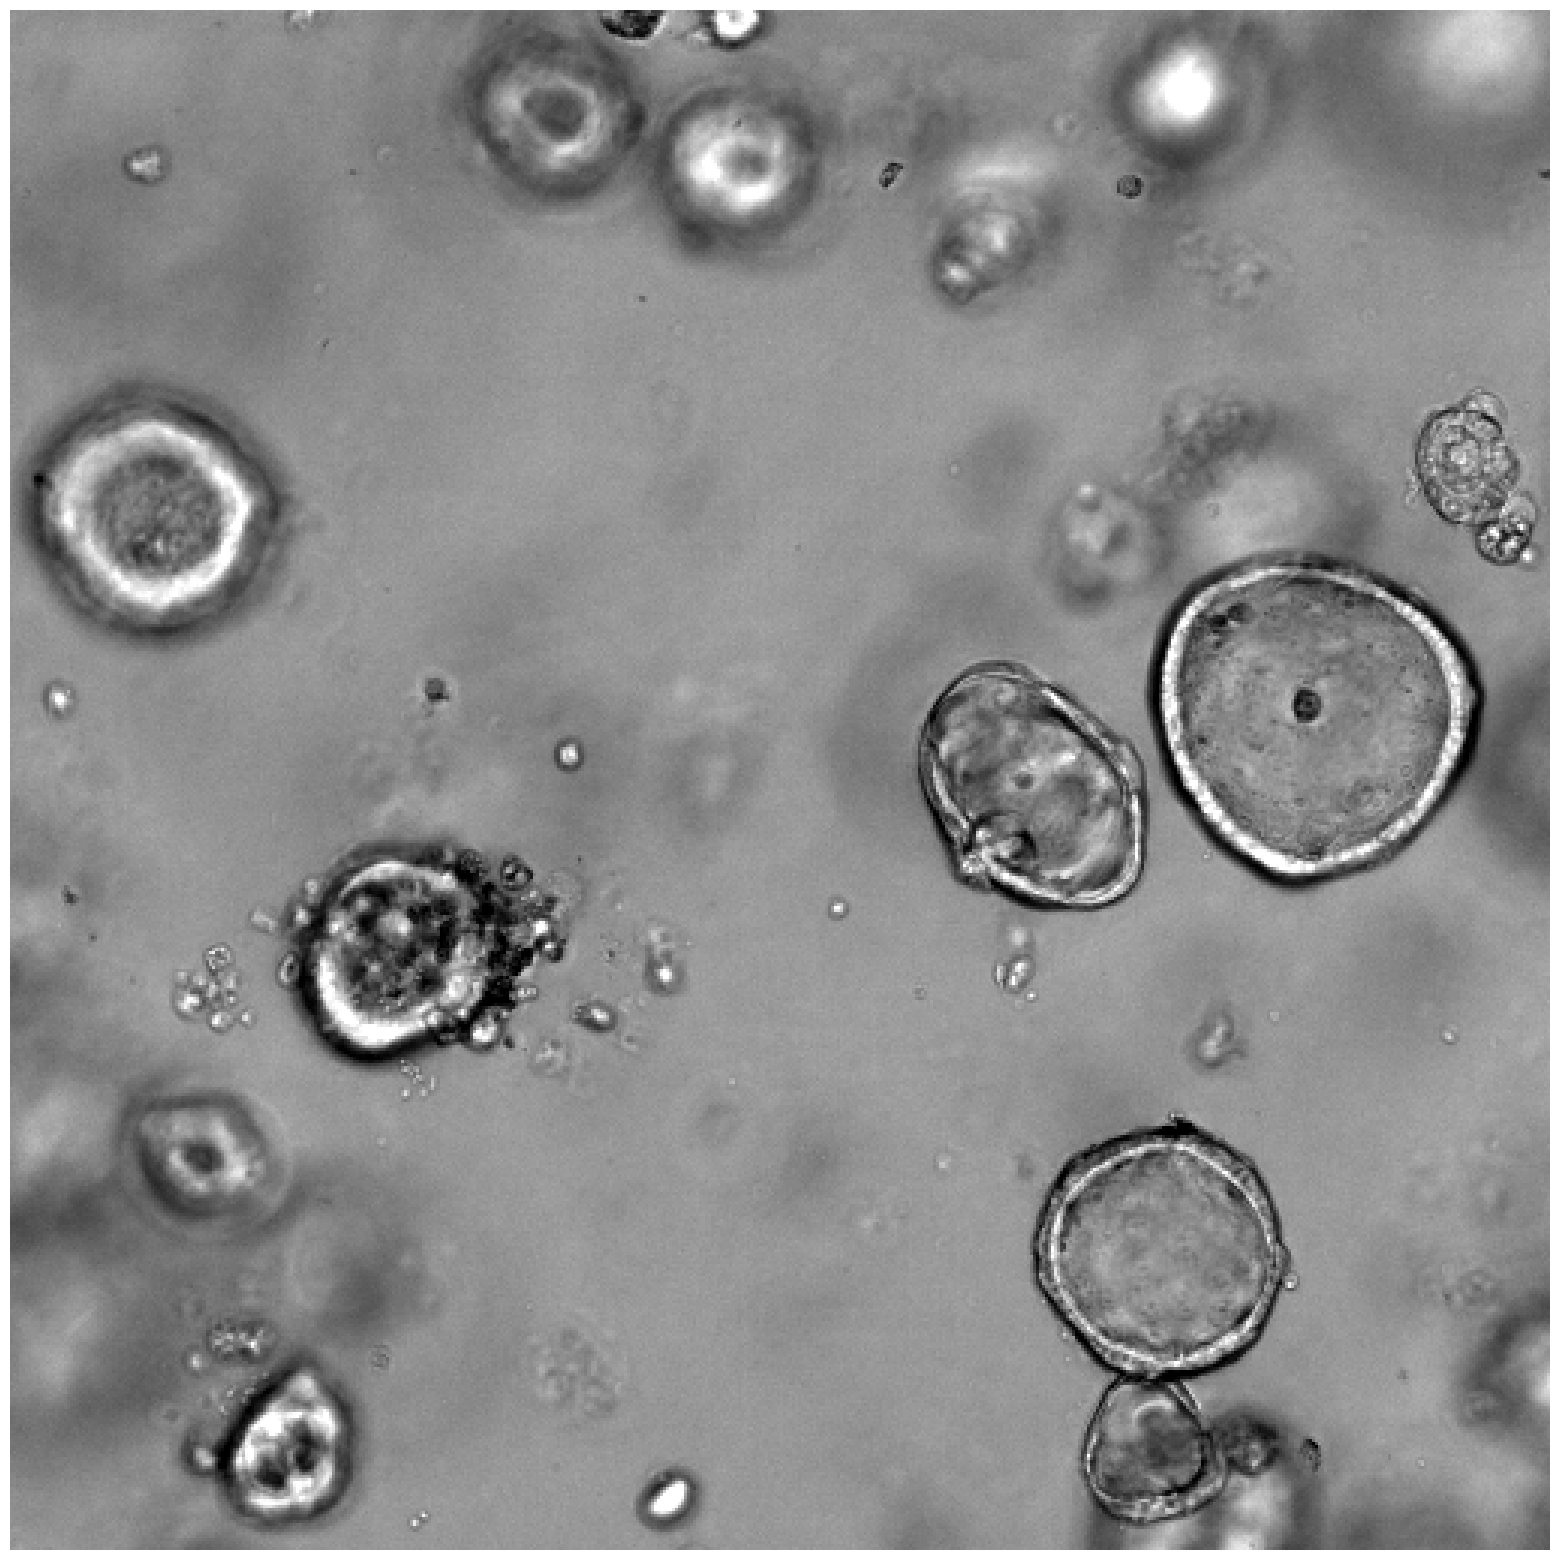

In [7]:
# Read image
image = cv2.imread('images/46.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Print image
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

### First step: Automatic Mask Generation

For automatic mask generation we provide a SAM model to the `SamAutomaticMaskGenerator` class. We set the path below to the SAM checkpoint.

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks we just need to run `generate` on an image.

In [9]:
masks = mask_generator.generate(image)

This function returns a list over masks. Containing information for each mask as a dictionary with various data about the mask.

In [10]:
# Get idea of how many masks we have
print(len(masks))
print(masks[0].keys())

75
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Now we show all the masks.

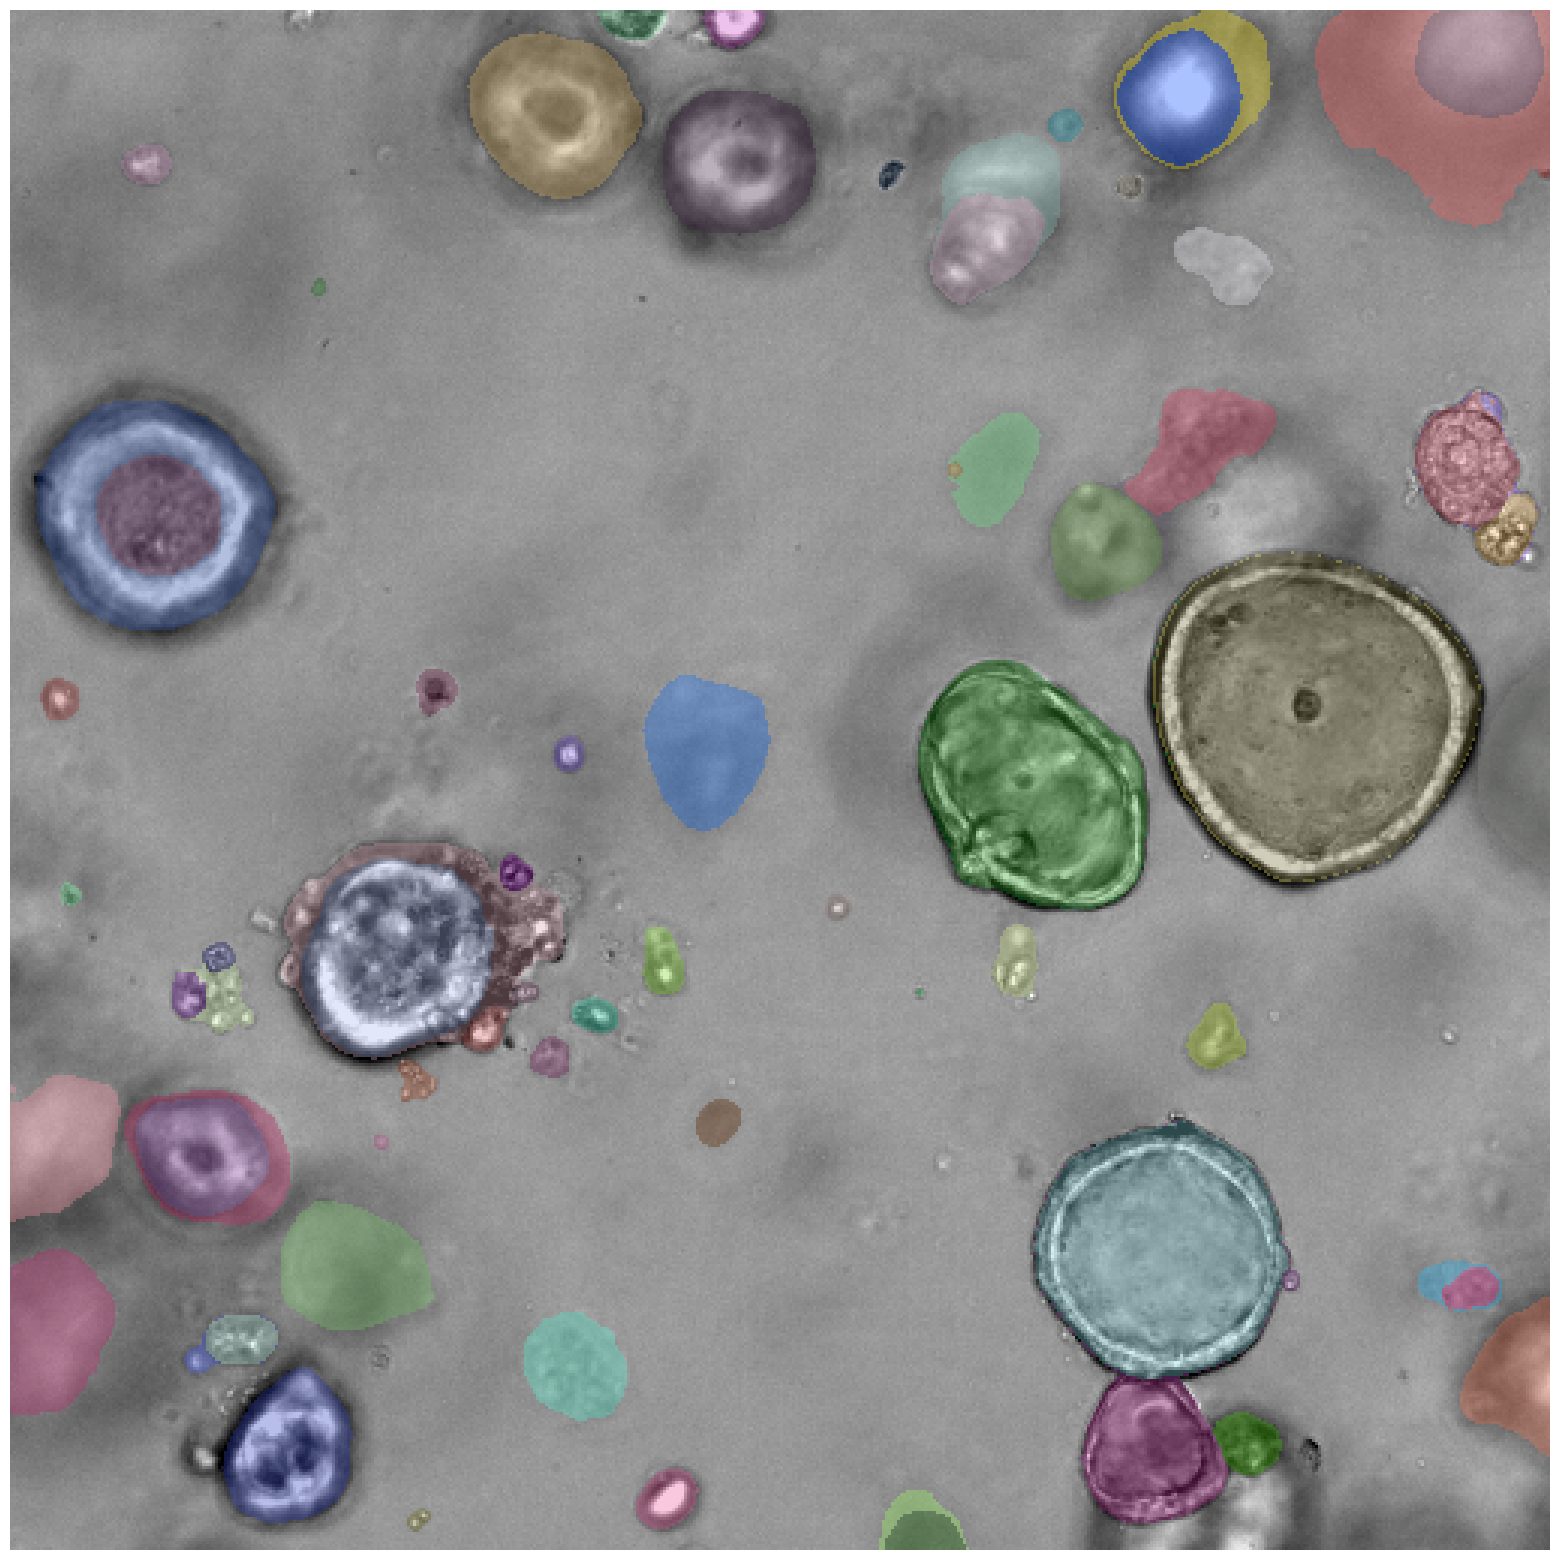

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

### Step 2: Give prompts

Instead of running automatic SAM predictor, we will give prompts in form of points to the model to predict the masks. We need `SamPredictor`for this.





In [12]:
predictor = SamPredictor(sam)


Process the image to produce an image embedding by calling SamPredictor.set_image. SamPredictor remembers this embedding and will use it for subsequent mask prediction.

In [13]:
predictor.set_image(image)

To select organoids, choose a point on them. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input. The chosen points will be shown as a star on the image. Red corresponds to backgorund and green to foreground.



In [14]:
input_point = np.array([[100, 480], [130, 320], [50, 175], [370, 480], [380, 410], [340, 260], [430, 250], [230, 200], [470, 100], [300, 400]])
input_label = np.array([1,1,1,1,1,1,1,0,0,0])

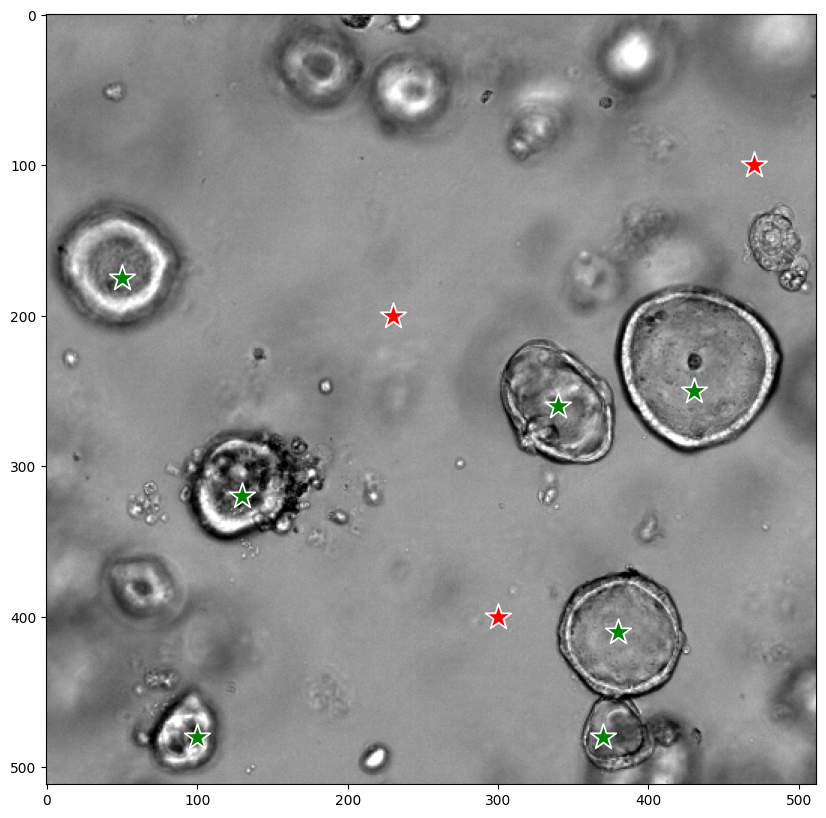

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

SamPredictor can take multiple input prompts for the same image, using predict_torch method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [19]:
points = torch.Tensor(input_point).to(predictor.device).unsqueeze(1)
labels = torch.Tensor([int(l) for l in input_label]).to(predictor.device).unsqueeze(1)
transformed_points = predictor.transform.apply_coords_torch(points, image.shape[:2])
print(labels)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


Transform the boxes to the input frame, then predict masks. SamPredictor stores the necessary transform as the transform field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [21]:
masks, scores, logits = predictor.predict_torch(
		point_coords=transformed_points,
		point_labels=labels,
		boxes=None,
		multimask_output=False,
	)

Show the masks.

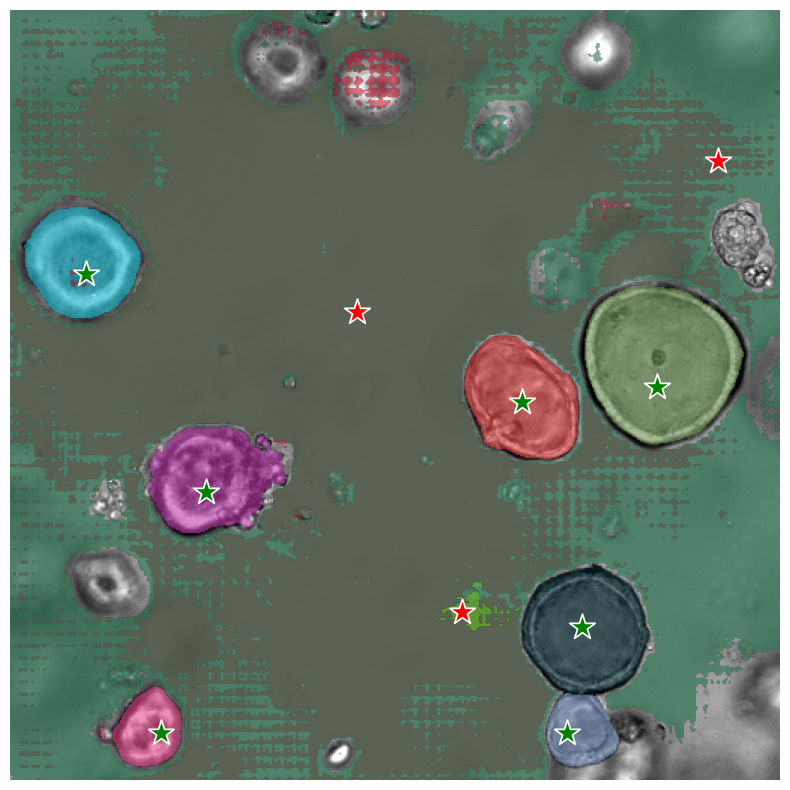

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()